In [1]:
    __test__ = dict(
        gold="""
        >>> g = a**str*[[str.upper]]|a**int*range|a**float*type
        >>> f = a/g*list
        >>> assert f(['keep it 💯', 10, 10.]) == [[["KEEP IT 💯"]], range(10), float]
        >>> assert copy(g).type()({}) is Ø""",
        simple=""">>> assert simple[range](10) == range(10)
        >>> assert simple[range][type](10) is range 
        >>> assert simple[range][type][type](10) is type
                
        Begin a composition with a decorator.
        >>> @simple.append
        ... def thang(x):
        ...     return range(x)
        >>> assert thang[len](10) is 10""",
        juxt="""
        >>> assert juxt[range](10) == [range(10)]
        >>> assert juxt[range][type](10) == [range(10), int]
        >>> assert juxt[range][type][str](10) == [range(10), int, '10']
        
        Create a juxtaposable object `model`.
        >>> @juxt.append
        ... def model(x): return range(x)

        Append more functions to the `model`
        >>> @model.append
        ... def _(x): return type(x)
        
        >>> assert isinstance(Juxtaposition({})(), dict) and isinstance(Juxtaposition([])(), list) and isinstance(Juxtaposition(tuple())(), tuple)""")

# Complex Composite Functions

Complex composite functions have real and imaginary parts that may except specific errors.  

## Composition

Composite functions use Python syntax to append callable objects to compositions and juxtapositions.  

### Operator 

In [2]:
    from functools import partialmethod, wraps, partial
    
    import operator
    from collections import Sized, Mapping
    from toolz import isiterable, excepts, identity, complement, concat, reduce, groupby
    import sys
    import inspect

    from copy import copy

    dunder = '__{}__'.format
    
    __all__ = 'a', 'an', 'the', 'simple', 'flip', 'parallel', 'star', 'do', 'preview', 'x',\
    'op', 'juxt', 'cache', 'store', 'Ø', 'Composition', 'Operation', \
    'Juxtaposition', 'Proposition', 'Exposition', 'Imposition'

In [3]:
    binop = 'add', 'sub', 'mul', 'truediv', 'floordiv', 'mod', 'lshift', 'rshift'
    boolop =  'gt', 'ge', 'le', 'lt', 'eq', 'ne'
    nop = 'abs', 'pos', 'neg', 'pow'

Composing function strictly through the Python datamodel.

In [4]:
    def call(object, *tuple, Exception=None, **dict):  
        """Call the object with an argument tuple, a keyword dict, and E
        
        >>> assert call(10) is 10
        >>> assert call(range, 10, 20) == range(10, 20)"""
        return (
            excepts(Exception, object, identity) if Exception else object
        )(*tuple, **dict) if callable(object) else object
    
    def null(*tuple, **dict): 
        """A null/identity function that returns the first arguments if it exists.
        
        >>> assert not null(**dict(foo=42))
        >>> assert null(10, 20, dict(foo=42)) is 10
        """
        return tuple[0] if tuple else None

In [5]:
    class Self(partial):
        """Supply partial arguments to objects.
        
        >>> assert Self(str.replace, 'a', 'b')('abc') == 'bbc'
        """
        def __call__(x, object): return x.func(object, *x.args, **x.keywords)

In [6]:
    class State:        
        """State attributes for pickling and copying propositions."""
        
        def __hash__(x): return hash(map(hash, x))
        
        def __getstate__(x):
            return tuple(getattr(x, slot, None) for slot in x.__slots__)
        
        def __setstate__(x, tuple):
            return list(
                setattr(x, str, object) for str, object in zip(x.__slots__, tuple)
            ) and x
        
        @property
        def __name__(x): return type(x).__name__
        
        __signature__ = inspect.signature(null)

In [7]:
    class flip(State):
        """Flip the argument of a callable.
        
        >>> assert flip(range)(20, 10) == range(10, 20)
        """
        __slots__ = 'callable',
        def __init__(x, callable): x.callable = callable
        def __call__(x, *tuple, **dict): return call(x.callable, *reversed(tuple), **dict)

In [8]:
    class Outer(State):
        __slots__ = 'callable',
        def __init__(x, object=None):
            x.callable = list() if object is None else object

        def __iter__(x):
            # Juxt is defined way later on unfortunately, but this is the most efficient place.
            yield from map(
                Juxt, dict.items(x.callable) if isinstance(x.callable, dict) else x.callable)
            
        def __call__(x, *tuple, **dict): 
            for callable in x: tuple, dict = (call(callable, *tuple, **dict),), {}
            return null(*tuple, **dict)
        
        def __len__(x):  return len(x.callable) if isinstance(x.callable, Sized) else 0
        def __repr__(x): return repr(x.callable)
        def __bool__(x): return bool(len(x))

In [9]:
    class Inner(Outer):                        
        def __iter__(x): 
            yield from x.callable and super().__iter__() or  (True,)
        
        def __call__(x, *tuple, **dict):
            object = super().__call__(*tuple, **dict)
            return object if object else Null(x.callable)

    class Ø(BaseException): 
        """An Inner callable may return a Ø Exception."""
        def __bool__(x): return False
        
    Null = Ø

In [10]:
    def _is_isinstance(object):
        """Prepare types and types as isinstance functions.
        
        >>> assert _is_isinstance(int)(10) and not _is_isinstance(int)('10')
        """
        if isinstance(object, type) and object is not bool: object = object,
        if isinstance(object, tuple): object = Self(isinstance, object)
        return object

In [11]:
    class Pose(State):
        """Pose a complex function with Inner and Outer callable. The Outer callable may accept exceptions. 
        Pose is combined with the prefixes Pro, Ex, Im, and Juxt to evaluate inner call methods. 
        """
        __slots__ = 'Inner', 'Outer', 'Exception'
        _repr_token_ = '^'
        def __init__(x, inner=None, outer=None, *, exception=None):
            inner = _is_isinstance(inner)
            if inner is not None and not isiterable(inner) or isinstance(inner, Pose):
                inner = [inner]
            
            for name in ('inner', 'outer'):
                object = locals().get(name)
                if object is not None and not isiterable(object) or isinstance(object, Pose):
                    locals()[name] = [object]

            x.Inner, x.Outer, x.Exception = Inner(inner), Outer(outer), exception
            
        def __bool__(x): return bool(x.Outer)

        def __repr__(x): return x._repr_token_.join(map(repr, (x.Inner, x.Outer)))
        
        def __call__(x, *tuple, **dict):
            return call(x.Outer, *tuple, **dict, Exception=dict.pop('Exception', x.Exception))

In [12]:
    class Juxt(Pose):
        """Juxtapose arguments cross callables."""
        def __new__(x, object=None, **dict):
            """Juxtapose is used generically to iterate through Sequences and Mappings. The
            new method returns callables and initializes everything else.  When called, Juxt 
            will return an object with the same type as Juxt.Outer.
            """
            if callable(object): return object
            if object is None: object = list()
            if isiterable(object) and not isinstance(object, str):
                x = super().__new__(x)
                return x.__init__(**dict) or x
            return object
            
        def __init__(x, outer=None, **dict): super().__init__(outer=outer, **dict)
        
        def __call__(x, *args, **kwargs):
            iter = (call(callable, *args, **kwargs) for callable in x.Outer)
            return type(x.Outer.callable)(iter) if isinstance(x.Outer.callable, Sized) else iter

# Composites

In [13]:
    class Pro(Pose):
        """Propose a non-null inner condition then evaluate the outer function."""
        def __call__(x, *tuple, **dict):
            object = x.Inner(*tuple, **dict)
            if x.Outer: return object if isinstance(object, Null) else super().__call__(*tuple, **dict)
            
            # If there is not outer function return a boolean.
            return not isinstance(object, Null)
        

In [14]:
    class Ex(Pose):
        """Pipe non-null inner return values to the outer callable."""        
        _repr_token_ = '&'
        def __call__(x, *tuple, **dict):
            object = x.Inner(*tuple, **dict)
            if object is True: object = null(*tuple, **dict)
            return object if isinstance(object, Null) else super().__call__(object)

In [15]:
    class Im(Pose):
        """If the inner function is Null evaluate the outer function."""
        _repr_token_ = '|'
        def __call__(x, *tuple, **dict):
            object = x.Inner(*tuple, **dict)
            if object is True: object = null(*tuple, **dict)
            return super().__call__(*tuple, **dict) if isinstance(object, Null) else object

In [16]:
    def _inner_(x): return [] if isinstance(x, Lambda) else [x]

In [17]:
    class Conditions:
        # Lambda initializes propositions.
        # The [*]positions are defined later.
        def __pow__(x, object): return Proposition(inner=_inner_(x) + [_is_isinstance(object)])
        def __and__(x, object): return Exposition(inner=_inner_(x), outer=[object])
        def __or__(x, object):  return Imposition(inner=_inner_(x), outer=[object])        
        def __xor__(x, object): return setattr(x, 'exceptions', object) or x
        
        then = __and__
        ifnot = __or__
        instance = ifthen = __pow__
        excepts = __xor__

In [18]:
    class __getattr__(object):
        def __init__(x, object, callable=None, parent=None):
            x.object, x.callable, x.parent = object, callable, parent

        def __getattr__(x, object):
            parent = x.callable
            # Convert the attribute to a callable.
            if x.callable: object = getattr(x.callable, object)
    
            if object in sys.modules: object = sys.modules.get(object)
            
            elif isinstance(object, str):
                for module in map(__import__, Attributes.shortcuts):
                    if hasattr(module, object): 
                        object = getattr(module, object)
                        break
                else: raise AttributeError(object)
            
            # Decorate the discovered attribute with the correct partials or call.
            wrapper = False
            
            for decorator, set in Attributes.decorators.items():
                if object in set: 
                    object = partial(decorator, object)
                    break
            else:                
                if callable(object) and not isinstance(object, type): 
                    wrapper = wraps(object)
                    object = partial(isinstance(parent, type) and Self or partial, object)
            
            # Wrap the new object for interaction
            object = __getattr__(x.object, object, parent) 
            return wrapper(object) if wrapper else object

        def __call__(x, *tuple, **dict):
            object = x.callable
            return x.object.append(
                object(*tuple, **dict) if isinstance(object, partial) else partial(object, *tuple, **dict))

        def __repr__(x): 
            return repr(isinstance(x.callable, partial) and x.callable.args and x.callable.args[0] or x.callable)
            

        def __dir__(x):
            if not x.callable or isinstance(x, Attributes):
                base = (
                    list(filter(Self(complement(str.__contains__), '.'), sys.modules.keys())) 
                    + list(concat(dir(__import__(module)) for module in Attributes.shortcuts)))
            else:
                base = dir(x.callable)
            return super().__dir__() + base

In [19]:
    class Attributes:
        """
        >>> assert not any(x in dir(x) for x in sys.modules if not '.' in x)
        >>> assert all(x in dir(a) for x in sys.modules if not '.' in x)
        """
        shortcuts = 'statistics', 'toolz', 'requests', 'builtins','json', 'pickle', 'io', 'collections', \
        'itertools', 'functools', 'pathlib', 'importlib', 'inspect', 'operator'
        decorators = dict()
        
        def __getattr__(x, attr):
            """Access attributes from sys.modules or x.shortcuts"""
            return __getattr__(x).__getattr__(attr)
        
        def __dir__(x): return dir(__getattr__(x))

    Attributes.decorators[Self] = [__import__('fnmatch').fnmatch]
    Attributes.decorators[call] = operator.attrgetter('attrgetter', 'itemgetter', 'methodcaller')(operator)
    Attributes.decorators[Self] += [item for item in vars(operator).values() if item not in Attributes.decorators[call]]

In [20]:
    class Append:
        def append(x, object): return x.Outer.callable.append(object) or x
        def __getitem__(x, object): return x.append(object)

In [21]:
    class Symbols:
        """Operations that operator on containers.
        
        >>> assert a@range == a.groupby(range)
        >>> assert a/range == a.map(range)
        >>> assert a//range == a.filter(range)
        >>> assert a%range == a.reduce(range)
        >>> assert copy(a%range) == a.reduce(range)
        """        
        def _left(x, callable, object=None, partial=Self):
            return x.append(callable if object is None else partial(callable, object))    
    
        def _right(right, attr, left):
            return getattr(Symbols._left(Proposition(), left), dunder(attr))(right)            
        
        __truediv__ = map = partialmethod(_left, map, partial=partial)
        __floordiv__ = filter = partialmethod(_left, filter, partial=partial)
        __mod__ = reduce = partialmethod(_left, reduce, partial=partial)
        __matmul__ = groupby =  partialmethod(_left, groupby, partial=partial)
        __add__ = __mul__ = __sub__ = __rshift__= Append.__getitem__
        
        def __lshift__(x, object): return x.append(Do(object))
        do = __lshift__

    list(setattr(Symbols, '__r' + dunder(attr).lstrip('__'), partialmethod(Symbols._right, attr))
         for attr in binop);
        

# Juxtapositions

In [22]:
    class Position(Append, Conditions, Attributes, Symbols): ...

In [23]:
    class Proposition(Pro, Position): 
        """Evaluate the outer callable if the inner callable is ~Null."""
    class Exposition(Ex, Position): 
        """Pass ~Null inner function return values as input to the outer function."""
    class Imposition(Im, Position): 
        """Evaluate the other outer function is the inner function is Null."""
    class Juxtaposition(Juxt, Position): 
        """Pass arguments to all callables in all iterables."""        
    IfThen, IfNot = Exposition, Imposition

In [24]:
    class Lambda:
        def append(x, object):  
            tuple, dict = getattr(x, 'args', []), getattr(x, 'kwargs', {})
            return x().append(partial(object, *tuple, **dict) if tuple or dict else object)
        
        def __bool__(x): return False
        
    class Composition(Lambda, Proposition): 
        __slots__ = Pose.__slots__ + ('args', 'kwargs')
        
    class Simple(Composition):
        def __call__(x, *tuple, **dict): 
            if tuple or dict:
                x = copy(x)
                x.args, x.kwargs = tuple, dict
                return x
            return super().__call__(dict.get('inner', None), *tuple, **dict)

In [25]:
    composite = compositon = Composition(outer=[Proposition])
    a = an = the = simple = λ = Simple(outer=[Proposition])
    juxt = juxtaposition = Simple(outer=[Juxtaposition])

In [26]:
    class Operate(Proposition):
        __wrapped__ = None
        __annotations__ = {}
        
        def __init__(x, *args, **kwargs): 
            super().__init__(None, *args, **kwargs)
            x.__qualname__ = '.'.join((__name__, type(x).__name__))
        def _left(x, callable, arg=None, partial=Self):
            return x.append(partial(callable, arg))

        def _right(x, callable, left):
            # I don't think this is correct
            return Operate._left(Operate(), callable, left, partial=partial)

        def _bool(x, callable, *args):
            return Operate(inner=[Self(callable, *args)], outer=[x])            
        
    for attr in binop + ('getitem',):
        op, rop =  getattr(operator, attr), '__r' + dunder(attr).lstrip('__')
        setattr(Operate, dunder(attr), partialmethod(Operate._left, op))
        setattr(Operate, rop, partialmethod(Operate._right, op))        
        
    list(setattr(Operate, dunder(attr), partialmethod(Operate._bool, getattr(operator, attr)))
         for attr in boolop)
    list(setattr(Operate, dunder(attr), partialmethod(Operate._left, getattr(operator, attr)))
         for attr in nop)
    pass

In [27]:
    class Operation(Lambda, Operate): 
        def append(x, object): return x().append(object)
        __qualname__ = 'Operation'
        
    x = op = Operation(outer=[Operate])

In [28]:
    class Star(Proposition):
        _repr_token_ = "*"
        def __call__(x, object, *tuple, **dict):
            if isinstance(object, Mapping): return super().__call__(*tuple, **(dict.update(object) or dict))
            return super().__call__(*object, *tuple, **dict)

    star = Simple(outer=[Star])

In [29]:
    class Do(Proposition):
        _repr_token_ = '>>'
        def __call__(x, *tuple, **dict): 
            super().__call__(*tuple, **dict)
            return null(*tuple, **dict)
    do = Simple(outer=[Do])

In [30]:
    class Preview(Proposition):
        """Eager proposition evaluation."""
        def __repr__(x): return repr(x())
        
    preview = Simple(outer=[Preview])

In [31]:
    class parallel(Proposition):
        """An embarassingly parallel proposition.
        
        >>> import joblib
        >>> def g(x): return x+10
        >>> assert parallel(4).range().map(x+10)(100)
        >>> assert parallel(4).range().map(a[range])(100)
        """
        _repr_token_ = '||'
        def __init__(x, jobs=4, *tuple, **dict):
            x.jobs = jobs
            super().__init__(*tuple, **dict)

        def map(x, object): return super().map(__import__('joblib').delayed(object))

        def __call__(x, *tuple, **dict):
            return __import__('joblib').Parallel(x.jobs)(super().__call__(*tuple, **dict))

        __truediv__ = map

In [32]:
    class store(dict):
        @property
        def __self__(x): return x.__call__.__self__
        def __init__(x, callable=None, *tuple, **dict):
            x.callable = Proposition(*tuple, **dict) if callable is None else callable
            super().__init__(*tuple, **dict)
        def __call__(x, *tuple, **dict):
            x[tuple[0]] = x.callable(*tuple, **dict)
            return x[tuple[0]]

In [33]:
    class cache(store):
        def __call__(x, *tuple, **dict):
            if tuple[0] not in x: return super().__call__(*tuple, **dict)
            return x[tuple[0]]

# Developer

[NbConvertApp] Converting notebook composites.ipynb to python
[NbConvertApp] Writing 18263 bytes to composites.py
wrote composites.html
parsing /Users/tonyfast/composites/composites.py...


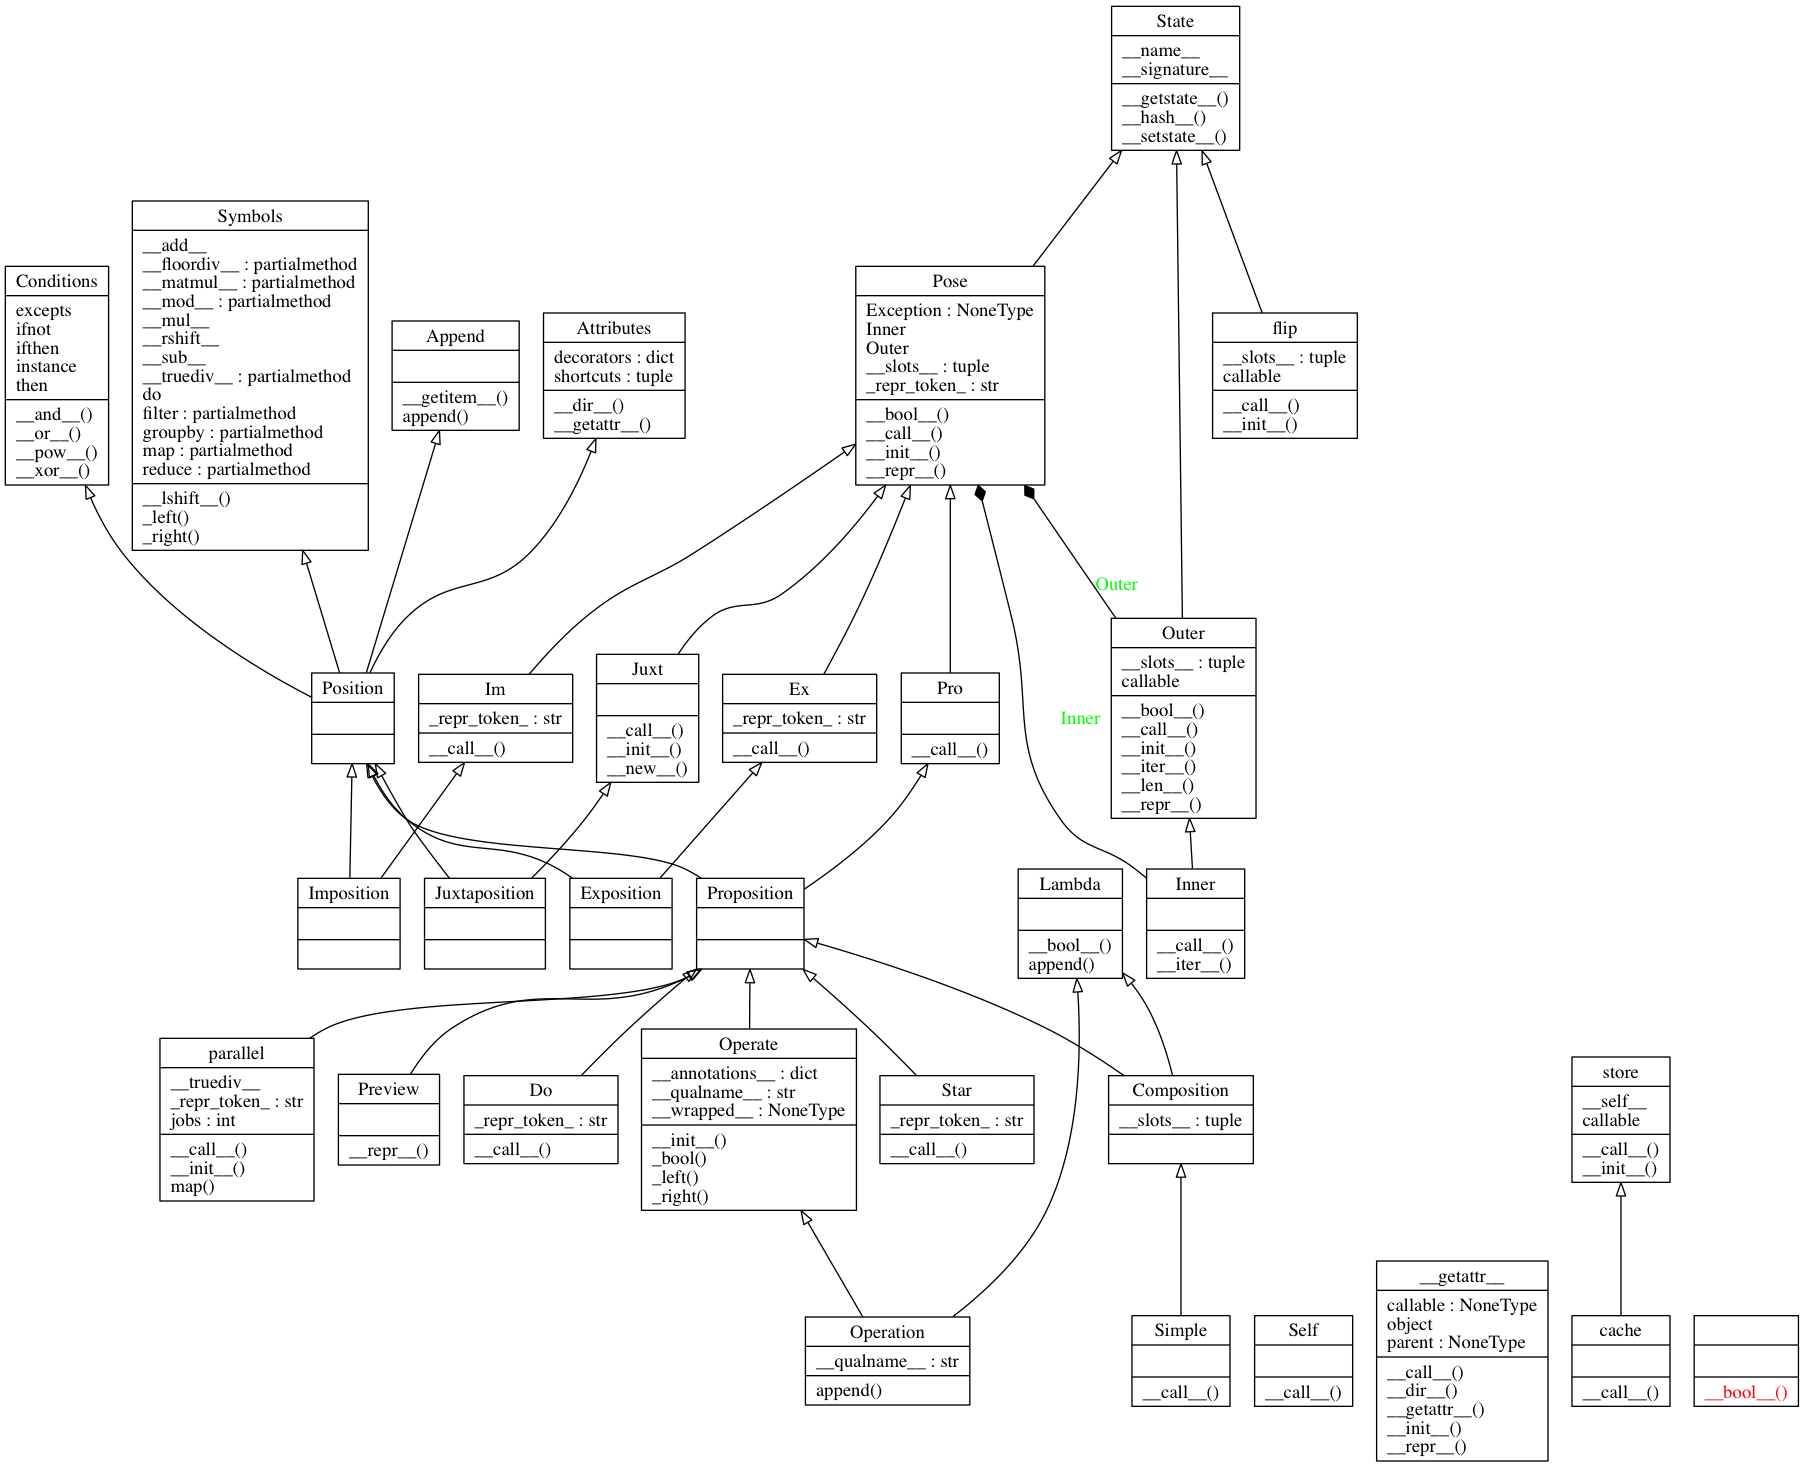

**********************************************************************
File "__main__", line ?, in __main__.Symbols
Failed example:
    assert a@range == a.groupby(range)
Exception raised:
    Traceback (most recent call last):
      File "/Users/tonyfast/anaconda/envs/p6/lib/python3.6/doctest.py", line 1330, in __run
        compileflags, 1), test.globs)
      File "<doctest __main__.Symbols[0]>", line 1, in <module>
        assert a@range == a.groupby(range)
    AssertionError
**********************************************************************
File "__main__", line ?, in __main__.Symbols
Failed example:
    assert a/range == a.map(range)
Exception raised:
    Traceback (most recent call last):
      File "/Users/tonyfast/anaconda/envs/p6/lib/python3.6/doctest.py", line 1330, in __run
        compileflags, 1), test.globs)
      File "<doctest __main__.Symbols[1]>", line 1, in <module>
        assert a/range == a.map(range)
    AssertionError
****************************************

In [34]:
    if __name__ == '__main__':
        if 'runtime' in sys.argv[-1]:
            from IPython import get_ipython, display
            !jupyter nbconvert --to python --TemplateExporter.exclude_input_prompt=True composites.ipynb
            # Juxtaposition still wont work
            !python -m pydoc -w composites
            !pyreverse -o png -pcomposites -fALL composites
            display.display(display.Image('classes_composites.png'), display.IFrame('composites.html', height=600, width=800))
            __import__('doctest').testmod()
            !ipython -m doctest  composites.py
            !python -m pydoc -w composites

            !autopep8 --in-place --aggressive --aggressive composites.py
            !flake8 composites.py --ignore E501,E704,W503
        else:
            print('run from cli')